In [1]:
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt


def get_scores_accuracy(X_train, X_test, Y_train, Y_test):
    clf = linear_model.LogisticRegression()
    clf.fit(X_train, Y_train)
    y_pred = clf.predict(X_test)
    y_pred = (y_pred > 0).astype(int)
    success = (Y_test == y_pred).astype(int)
    acc = success.mean()

    return round(acc, 3), success

In [2]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

class MRMR:
    def __init__(self, X, Y, task):
        self.target = mutual_info_classif(X, Y) if task == "cls" else mutual_info_regression(X, Y)
        self.matrix = [mutual_info_regression(X, X[:, i]) for i in range(X.shape[1])]
        self.X = X
        self.range()

    def range(self):
        possible_idx = list(range(len(self.target)))
        self.idx = [np.argmax(self.target)]
        possible_idx.remove(self.idx[0])
        for _ in range(1, len(self.target)):
            scores = [self.target[i] / (self.matrix[i][self.idx].sum() + 1e-9) for i in possible_idx]
            best_idx = possible_idx[np.argmax(scores)]
            self.idx.append(best_idx)
            possible_idx.remove(best_idx)

    def top_k(self, k):
        return self.X[:, self.idx[:k]]

In [3]:
from scipy.special import binom

def compute_k(alpha, p, n):
    k = -1
    prob = 0
    for i in range(n + 1):
        prob += binom(n, i) * (p ** i) * ((1 - p) ** (n - i))
        if prob <= alpha:
            k = i
        else:
            break
    return k

In [4]:
import pandas as pd
from sklearn.utils import shuffle

test_len = 125

data = pd.read_csv("D:/n.semenov/Diploma/tda4atd/data_with_model_answers.csv")
features = np.load("D:/n.semenov/Diploma/tda4atd/features.npy")
Y = np.array(data["is_right"]).astype(int)
features, Y = shuffle(features, Y, random_state=52)

X_train, X_test = features[test_len:], features[:test_len]
Y_train, Y_test = Y[test_len:], Y[:test_len]

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
selector = MRMR(X_train, Y_train, "cls")
selector.range()
best_idx = selector.idx

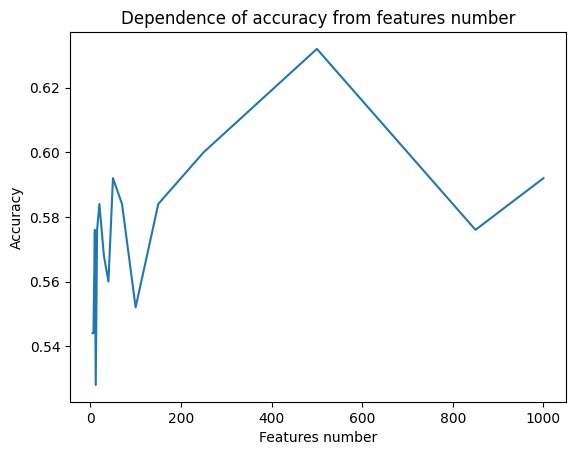

In [ ]:
Ns = [5, 7, 10, 12, 15, 20, 25, 30, 40, 50, 70, 100, 150, 250, 500, 700, 850, 1000]
ACCs = []
best_n, best_acc = -1, -1

for n in Ns:
    X_tr, X_tst = X_train[:, best_idx[:n]], X_test[:, best_idx[:n]]
    acc, _ = get_scores_accuracy(X_tr, X_tst, Y_train, Y_test)
    ACCs.append(acc)
    if acc > best_acc:
        best_n, best_acc = n, acc

plt.title("Зависимость точности от количества признаков")
plt.ylabel("Точность")
plt.xlabel("Количество признаков")
plt.plot(Ns, ACCs)
plt.savefig("dependense.png", dpi = 600)

In [32]:
X_train, X_test = X_train[:, best_idx[:best_n]], X_test[:, best_idx[:best_n]]
best_acc, Z = get_scores_accuracy(X_train, X_test, Y_train, Y_test)
phi = Z.sum()
print(best_acc, phi)

0.624 78


In [34]:
Ps = [0.55, 0.58, 0.6, 0.7, 0.8, 0.9]
Alphas = [0.7, 0.8, 0.9, 0.95]

for alpha in Alphas:
    for p in Ps:
        k = compute_k(alpha, p, test_len)
        print(str([k, phi > k]), end = "\t")
    print()


[71, True]	[74, True]	[77, True]	[89, False]	[101, False]	[113, False]	
[72, True]	[76, True]	[79, False]	[91, False]	[103, False]	[114, False]	
[75, True]	[79, False]	[81, False]	[93, False]	[105, False]	[116, False]	
[77, True]	[81, False]	[83, False]	[95, False]	[106, False]	[117, False]	
